<a href="https://colab.research.google.com/github/AndreasICL/MSc_Project/blob/master/code/RVFF_ND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.2.0 > /dev/null
!pip install gpflow > /dev/null
!pip install gast > /dev/null
!pip install observations > /dev/null

In [2]:
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt

from gpflow.config import default_float, default_jitter
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float
from gpflow.base import TensorLike
from gpflow import covariances as cov
from gpflow import kullback_leiblers as kl
from gpflow.covariances import Kuu
from gpflow.covariances import Kuf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import numpy as np
import os
import sys
from shutil import copyfile, rmtree
import pickle 

import observations

import warnings

warnings.filterwarnings("ignore")
sys.path.insert(0,'./VFF/')

from RVFF_IV_ND import RVFF_ND

In [3]:
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

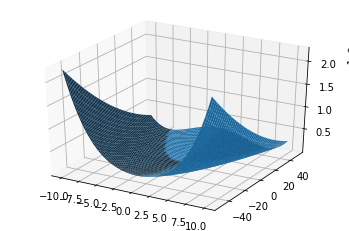

In [4]:
from mpl_toolkits.mplot3d import Axes3D

def rosenbrock(x, y, a, b):
  return ( a - x ) ** 2 + b * ( y - x ** 2 ) ** 2

xn = 50
yn = 50

x = np.linspace(-10, 10, xn)
y = np.linspace(-50, 50, yn)

X = np.meshgrid(x, y)

Y = rosenbrock( X[0], X[1], 1, 100 )

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X[0], X[1], Y)
plt.show()

noise = np.random.multivariate_normal(np.zeros(Y.shape[0]), 200000000 * np.identity(Y.shape[0]), size=Y.shape[0])
Y = Y + noise

# Reshape for SGPR
X = np.linspace([-10, -50], [10, 50], xn * yn)
Y = Y.reshape(-1)

In [5]:
from scipy.optimize import minimize, fmin_l_bfgs_b

tf.config.experimental_run_functions_eagerly(True)

M = 100
inducing_variable = RVFF_ND( a=0, b=6, M=M, D=2 )

kernel = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)
kernel = gpflow.kernels.Product([kernel, kernel])

model = gpflow.models.SGPR(
    (X, Y), kernel=kernel, inducing_variable=inducing_variable
)

omegas = inducing_variable.omegas
phis = inducing_variable.phis

mean, std = model.predict_f(X, False, False)
print(mean.shape)
print(std.shape)
# std = tf.sqrt(std)
plot(Xtest, [(mean, std, 'r', 'c')])

gpflow.set_trainable(kernel, True)
gpflow.set_trainable(model.likelihood, True)
gpflow.set_trainable(model.inducing_variable.a, False)
gpflow.set_trainable(model.inducing_variable.b, False)
gpflow.set_trainable(model.inducing_variable.phis, False)
gpflow.set_trainable(model.inducing_variable.omegas, False)

@tf.function
def loss_closure():
  return -model.elbo()

def callback(step, variables, values):
  if step % 20 == 0:
    print(model.elbo())

optimizer = gpflow.optimizers.Scipy()
result = optimizer.minimize(loss_closure, model.trainable_variables, method='L-BFGS-B', step_callback=callback, options=dict(maxiter=1000, disp=True))

print("result:")
print(result.message)

print(model.elbo())

(100, 1)
(100, 1)
(1, 2500)
(100, 2)


NotImplementedError: ignored